In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

In [ ]:
df = pd.read_csv("wine-reviews.csv", usecols = ['country', 'description', 'points', 'price', 'variety', 'winery'])

In [ ]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


In [ ]:
df = df.dropna(subset = ["description", "points"])

In [ ]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


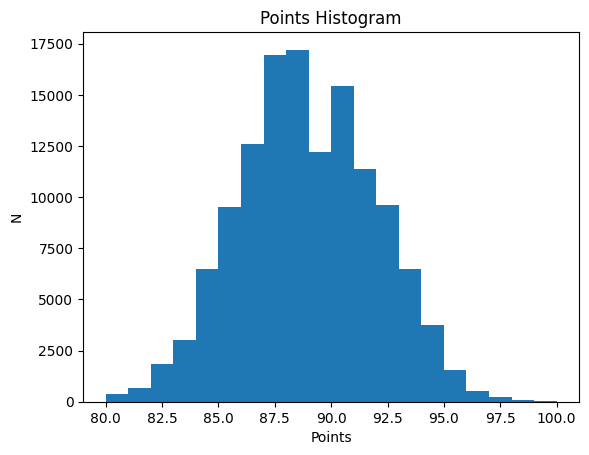

In [ ]:
plt.hist(df.points, bins = 20)
plt.title("Points Histogram")
plt.ylabel("N")
plt.xlabel("Points")
plt.show()

In [ ]:
df['label'] = (df.points >= 90).astype(int)
df = df[['description', 'label']]

In [ ]:
train, val, test = np.split(df.sample(frac = 1), [(int(0.8*len(df))), (int(0.9*len(df)))])

In [ ]:
len(train), len(val), len(test)

(103976, 12997, 12998)

In [ ]:
def df_to_dataset(dataframe, shuffle=True, batch_size=1024):
  df = dataframe.copy()
  labels = df.pop('label')
  df = df["description"]
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [ ]:
train_data = df_to_dataset(train)
valid_data = df_to_dataset(val)
test_data = df_to_dataset(test)

# Embedding + Model

In [ ]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=True)

In [ ]:
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(1024, 50), dtype=float32, numpy=
array([[ 0.4578112 , -0.20426852, -0.21232072, ..., -0.18674687,
         0.00192055,  0.06467643],
       [ 0.08959497, -0.26351166,  0.01105479, ...,  0.28237432,
        -0.11535753, -0.14130667],
       [ 0.48871163, -0.22533256,  0.04534571, ..., -0.01423836,
        -0.11061949,  0.12849365],
       ...,
       [ 0.3469143 , -0.01455182, -0.01537711, ..., -0.10609426,
        -0.29680076,  0.11321373],
       [ 0.3593411 , -0.18990779, -0.20523788, ..., -0.14266497,
        -0.21825632,  0.18361354],
       [ 0.46031952, -0.22672482, -0.19133304, ..., -0.07691199,
        -0.24114929,  0.1047309 ]], dtype=float32)>

In [ ]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model.evaluate(train_data)

102/102 [==============================] - 2s 17ms/step - loss: 0.6914 - accuracy: 0.5383


[0.6913912892341614, 0.538316547870636]

In [ ]:
model.evaluate(valid_data)

13/13 [==============================] - 0s 12ms/step - loss: 0.6914 - accuracy: 0.5363


[0.691352903842926, 0.5362775921821594]

In [ ]:
history = model.fit(train_data, epochs=5, validation_data=valid_data)

Epoch 1/5
102/102 [==============================] - 159s 2s/step - loss: 0.6312 - accuracy: 0.6315 - val_loss: 0.5082 - val_accuracy: 0.7816
Epoch 2/5
102/102 [==============================] - 151s 1s/step - loss: 0.4723 - accuracy: 0.7767 - val_loss: 0.3929 - val_accuracy: 0.8178
Epoch 3/5
102/102 [==============================] - 137s 1s/step - loss: 0.3967 - accuracy: 0.8275 - val_loss: 0.3723 - val_accuracy: 0.8296
Epoch 4/5
102/102 [==============================] - 137s 1s/step - loss: 0.3620 - accuracy: 0.8463 - val_loss: 0.3673 - val_accuracy: 0.8330
Epoch 5/5
102/102 [==============================] - 152s 1s/step - loss: 0.3378 - accuracy: 0.8587 - val_loss: 0.3713 - val_accuracy: 0.8316


<function matplotlib.pyplot.show(close=None, block=None)>

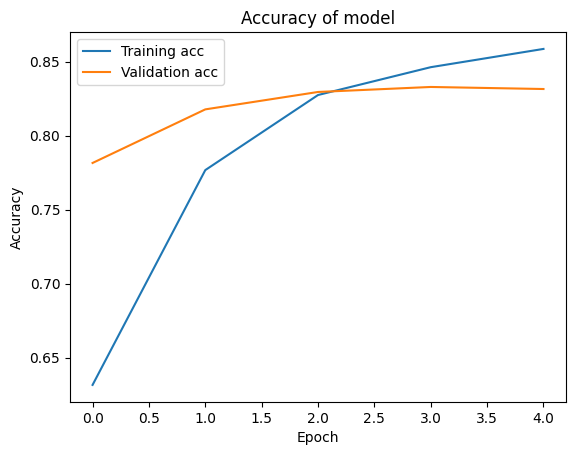

In [ ]:
plt.plot(history.history['accuracy'], label = 'Training acc')
plt.plot(history.history['val_accuracy'], label = 'Validation acc')
plt.title("Accuracy of model")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

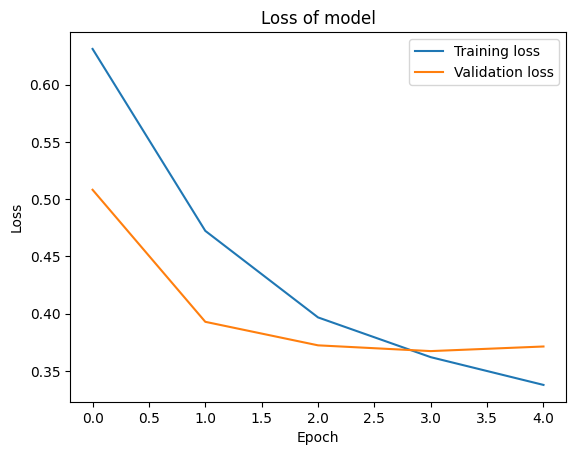

In [ ]:
plt.plot(history.history['loss'], label = 'Training loss')
plt.plot(history.history['val_loss'], label = 'Validation loss')
plt.title("Loss of model")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show

In [ ]:
model.evaluate(test_data)

13/13 [==============================] - 2s 171ms/step - loss: 0.3722 - accuracy: 0.8277


[0.37216970324516296, 0.8276658058166504]

# LSTM

In [ ]:
encoder = tf.keras.layers.TextVectorization(max_tokens=2000)
encoder.adapt(train_data.map(lambda text, label: text))

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'and', 'the', 'a', 'of', 'with', 'this', 'is', 'wine',
       'flavors', 'in', 'it', 'to', 'its', 'on', 'fruit', 'aromas',
       'palate', 'that'], dtype='<U17')

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=32,
        mask_zero=True
    ),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_data, epochs=5, validation_data=valid_data)

Epoch 1/5
102/102 [==============================] - 51s 454ms/step - loss: 0.5416 - accuracy: 0.7160 - val_loss: 0.3827 - val_accuracy: 0.8222
Epoch 2/5
102/102 [==============================] - 46s 447ms/step - loss: 0.3660 - accuracy: 0.8358 - val_loss: 0.3492 - val_accuracy: 0.8384
Epoch 3/5
102/102 [==============================] - 45s 437ms/step - loss: 0.3462 - accuracy: 0.8451 - val_loss: 0.3477 - val_accuracy: 0.8417
Epoch 4/5
102/102 [==============================] - 44s 428ms/step - loss: 0.3396 - accuracy: 0.8481 - val_loss: 0.3428 - val_accuracy: 0.8410
Epoch 5/5
102/102 [==============================] - 44s 428ms/step - loss: 0.3353 - accuracy: 0.8488 - val_loss: 0.3450 - val_accuracy: 0.8431


In [ ]:
model.evaluate(test_data)

13/13 [==============================] - 3s 233ms/step - loss: 0.3433 - accuracy: 0.8397


[0.3433425724506378, 0.8397445678710938]